In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.fftpack import fft2
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


In [9]:
def load_images_from_folder(folder_path):
    images, labels = [], []
    for label in os.listdir(folder_path):
        class_path = os.path.join(folder_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)
    return images, labels

def extract_fft_features(image):
    eq_img = cv2.equalizeHist(image)
    fft = np.abs(fft2(eq_img))
    fft_shifted = np.fft.fftshift(fft)
    fft_log = np.log1p(fft_shifted)

    energy = np.sum(fft_log**2)
    ent = entropy(fft_log.flatten())
    dominant = np.mean(np.sort(fft_log.flatten())[-20:])

    return [energy, ent, dominant]


In [10]:
base_path = "archive (2)/chest_xray"
train_images, train_labels = load_images_from_folder(os.path.join(base_path, "train"))
val_images, val_labels = load_images_from_folder(os.path.join(base_path, "val"))
test_images, test_labels = load_images_from_folder(os.path.join(base_path, "test"))


In [11]:
X_train = [extract_fft_features(img) for img in train_images]
X_val = [extract_fft_features(img) for img in val_images]
X_test = [extract_fft_features(img) for img in test_images]

y_train, y_val, y_test = np.array(train_labels), np.array(val_labels), np.array(test_labels)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [12]:
models = {
    "SVM": SVC(kernel='rbf', C=1),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier()
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model



🔍 SVM Evaluation on TEST Set:
Accuracy:  0.7467948717948718
Precision: 0.7377049180327869
Recall:    0.9230769230769231
F1 Score:  0.8200455580865603
              precision    recall  f1-score   support

      NORMAL       0.78      0.45      0.57       234
   PNEUMONIA       0.74      0.92      0.82       390

    accuracy                           0.75       624
   macro avg       0.76      0.69      0.70       624
weighted avg       0.75      0.75      0.73       624



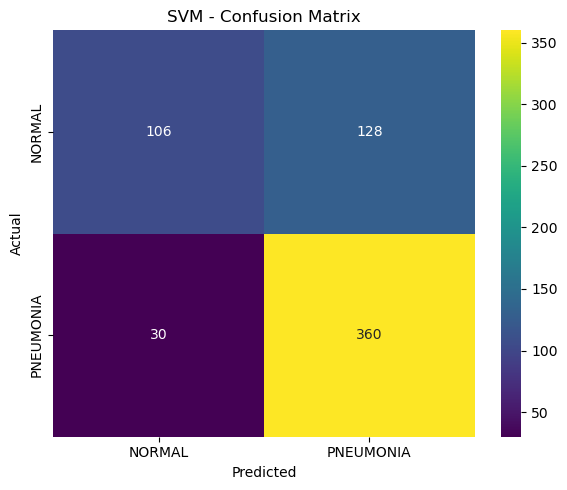


🔍 Random Forest Evaluation on TEST Set:
Accuracy:  0.7307692307692307
Precision: 0.726530612244898
Recall:    0.9128205128205128
F1 Score:  0.8090909090909091
              precision    recall  f1-score   support

      NORMAL       0.75      0.43      0.54       234
   PNEUMONIA       0.73      0.91      0.81       390

    accuracy                           0.73       624
   macro avg       0.74      0.67      0.68       624
weighted avg       0.73      0.73      0.71       624



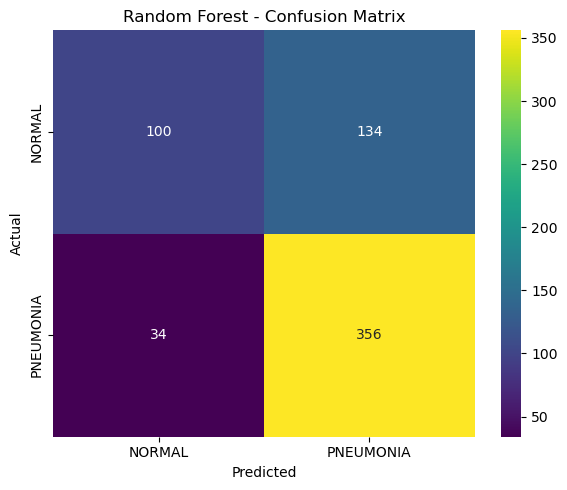


🔍 Gradient Boosting Evaluation on TEST Set:
Accuracy:  0.7564102564102564
Precision: 0.7510548523206751
Recall:    0.9128205128205128
F1 Score:  0.8240740740740741
              precision    recall  f1-score   support

      NORMAL       0.77      0.50      0.60       234
   PNEUMONIA       0.75      0.91      0.82       390

    accuracy                           0.76       624
   macro avg       0.76      0.70      0.71       624
weighted avg       0.76      0.76      0.74       624



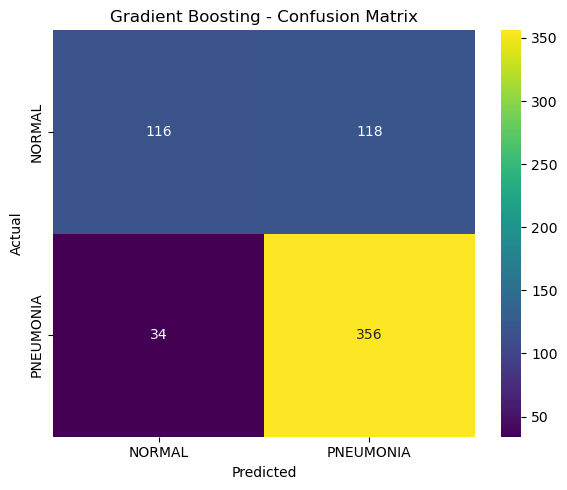

In [17]:


# Train and evaluate models
model_metrics = {}
trained_models = {}

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Predict
    y_pred = model.predict(X_test_scaled)

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label='PNEUMONIA')
    rec  = recall_score(y_test, y_pred, pos_label='PNEUMONIA')
    f1   = f1_score(y_test, y_pred, pos_label='PNEUMONIA')
    model_metrics[name] = [acc, prec, rec, f1]

    # Print detailed report
    print(f"\n🔍 {name} Evaluation on TEST Set:")
    print("Accuracy: ", acc)
    print("Precision:", prec)
    print("Recall:   ", rec)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()



📊 Overall Evaluation:

                   Accuracy  Precision    Recall  F1 Score
SVM                0.748397   0.738241  0.925641  0.821388
Random Forest      0.737179   0.730612  0.917949  0.813636
Gradient Boosting  0.750000   0.745798  0.910256  0.819861


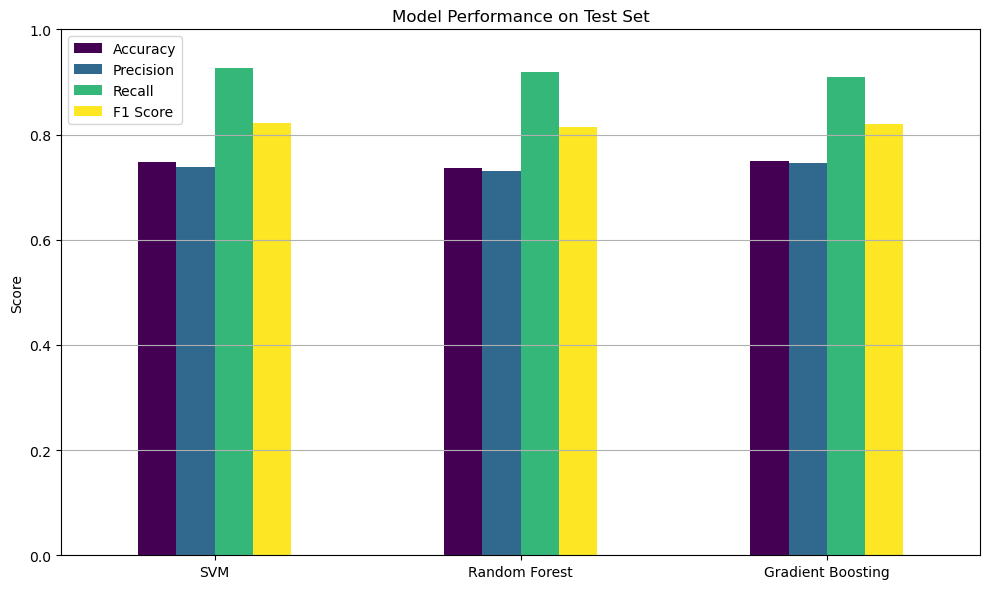

In [22]:


# Display all scores in one table
df = pd.DataFrame(model_metrics, index=["Accuracy", "Precision", "Recall", "F1 Score"]).T
print("\n📊 Overall Evaluation:\n")
print(df)

# Bar Chart for comparison
df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Test Set")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [24]:

# Best model selection
best_model_name = df["Accuracy"].idxmax()
best_model = trained_models[best_model_name]
print(f"\n✅ Best Model: {best_model_name} (F1 Score = {df.loc[best_model_name]['F1 Score']:.4f})")



✅ Best Model: Gradient Boosting (F1 Score = 0.8199)


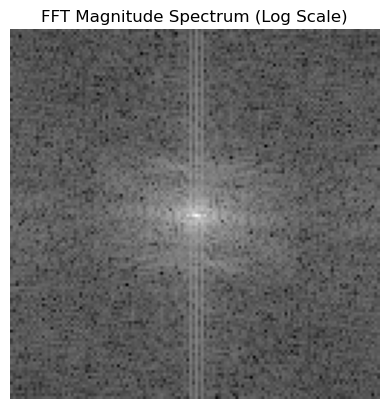

In [26]:
sample_img = train_images[0]
eq = cv2.equalizeHist(sample_img)
fft_mag = np.abs(fft2(eq))
fft_shifted = np.fft.fftshift(fft_mag)
fft_log = np.log1p(fft_shifted)

plt.imshow(fft_log, cmap='gray')
plt.title("FFT Magnitude Spectrum (Log Scale)")
plt.axis("off")
plt.show()


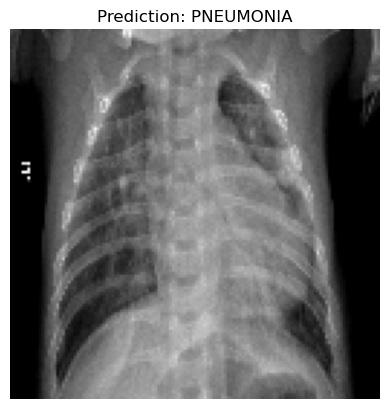


🧪 Example result: PNEUMONIA


In [27]:

# 🔟 Prediction helper
def predict_xray(image_path, model, scaler):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128))
    features = np.array(extract_fft_features(cv2.equalizeHist(img))).reshape(1,-1)
    pred = model.predict(scaler.transform(features))[0]
    plt.imshow(img, cmap='gray'); plt.title(f"Prediction: {pred}")
    plt.axis('off'); plt.show()
    return pred

# 🧪 Example prediction
example = os.path.join(base, "test/PNEUMONIA/person1_virus_13.jpeg")
print("\n🧪 Example result:", predict_xray(example, trained_models[best], scaler))

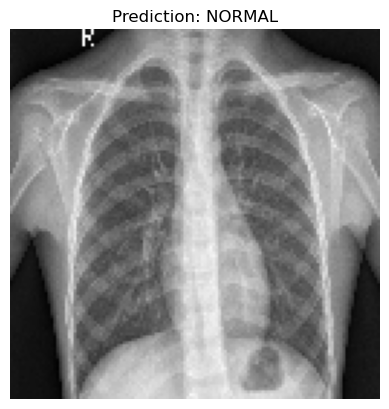

In [28]:
import matplotlib.pyplot as plt

def predict_xray(image_path, model, scaler):
    # Read and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (128, 128))  # Resize to the input size for the model
    eq = cv2.equalizeHist(img_resized)
    
    # Extract FFT features
    features = np.array(extract_fft_features(eq)).reshape(1, -1)
    
    # Scale features
    scaled = scaler.transform(features)
    
    # Make prediction
    prediction = model.predict(scaled)
    
    # Show image along with prediction
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Prediction: {prediction[0]}")
    plt.axis("off")  # Hide axis
    plt.show()
    
    return prediction[0]

# Example Usage
image_path = "archive (2)/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
result = predict_xray(image_path, best_model, scaler)


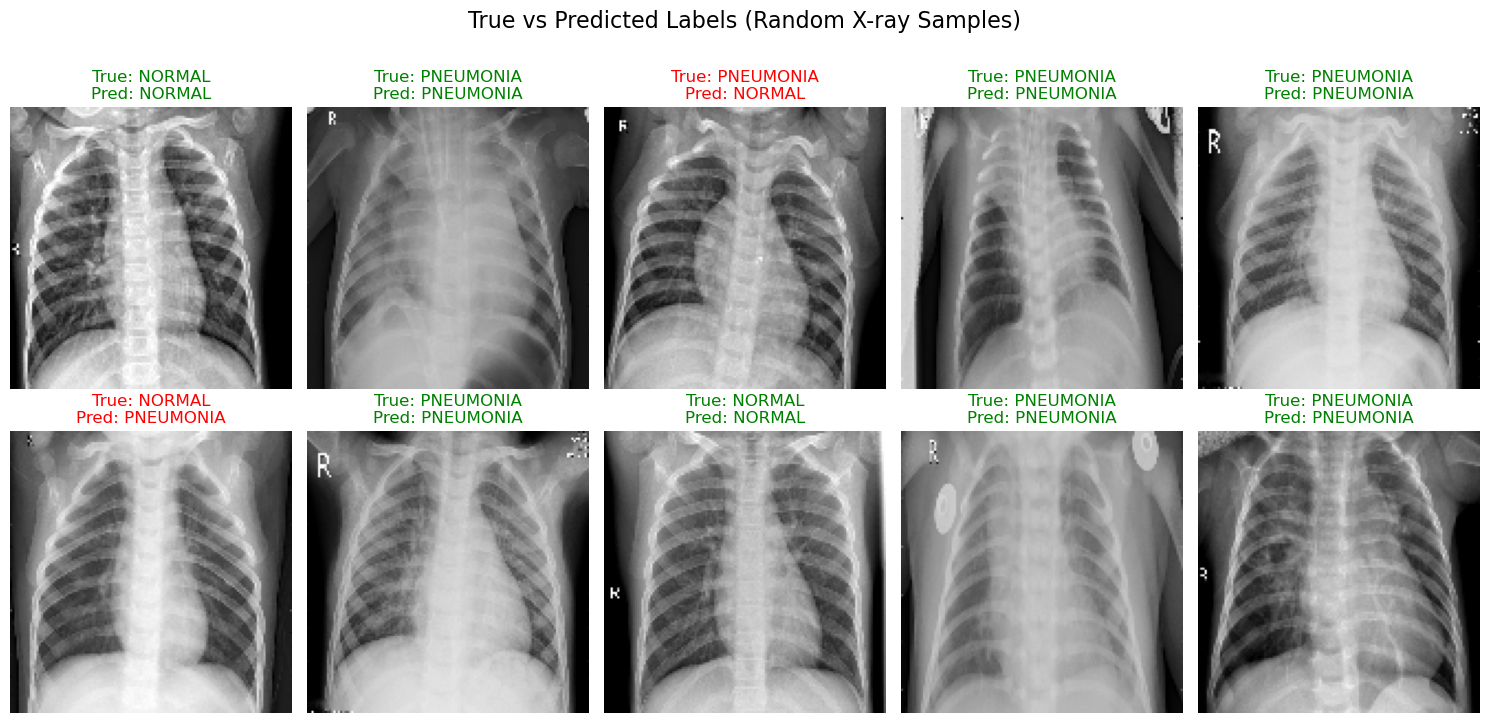

In [31]:
import random
from glob import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def random_predictions_from_test_set(test_dir, model, scaler, n=12):
    # Collect all image paths from test set
    normal_images = glob(os.path.join(test_dir, "NORMAL", "*.jpeg"))
    pneumonia_images = glob(os.path.join(test_dir, "PNEUMONIA", "*.jpeg"))
    all_images = normal_images + pneumonia_images

    # Randomly sample n images
    sampled_images = random.sample(all_images, n)

    # Plot predictions
    plt.figure(figsize=(15, 10))
    
    for i, image_path in enumerate(sampled_images):
        # Get true label from path
        true_label = "PNEUMONIA" if "PNEUMONIA" in image_path else "NORMAL"
        
        # Load and preprocess image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))
        eq = cv2.equalizeHist(img_resized)
        
        # Feature extraction
        features = np.array(extract_fft_features(eq)).reshape(1, -1)
        scaled = scaler.transform(features)
        
        # Prediction
        prediction = model.predict(scaled)[0]
        
        # Plotting
        plt.subplot(3, 5, i + 1)
        plt.imshow(img_resized, cmap="gray")
        plt.title(f"True: {true_label}\nPred: {prediction}", 
                  color=("green" if prediction == true_label else "red"))
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle("True vs Predicted Labels (Random X-ray Samples)", fontsize=16, y=1.05)
    plt.show()

# Example usage:
test_dir = "archive (2)/chest_xray/test"
random_predictions_from_test_set(test_dir, best_model, scaler, n=10)
